In [22]:
using CSV
using DataFrames

using DotEnv
DotEnv.load!()

using PyCall
np = pyimport("numpy")
counter = pyimport("collections").Counter;
sklearn_metrics = pyimport("sklearn.metrics")

using PyPlot

using Combinatorics
using LinearAlgebra
using Statistics

## Spinos dataset - Climate change-related content
PAPER: https://aclanthology.org/2022.lrec-1.405.pdf

In [38]:
spinos_df = CSV.read(ENV["SPINOS_PATH"], DataFrame);

In [44]:
first(spinos_df, 1)

Row,author_id,title,content,annotation,topic,subreddit,is_sarcastic,is_unsure,is_explicit,top_level_post,top_level_post_id,parents,parent_ids,timestamp
,String,String?,String,String31,String15,String31,String3?,String3?,String3?,String3,String7?,String3,String?,String31
1,475e2075e3f4ab3c4b92fd54d96e08464a00803a1b0aaec6703a5eff877f1e88,missing,"Why is it impossible to have a normal conversation with you? As soon as you are presented some (new?) information, you react evasively. Would it be so bad to have some new information?",stance_not_inferrable,climate-change,r/climatechange,missing,missing,missing,1,missing,1,missing,2020-01-07 22:44:40


In [90]:
size(spinos_df)

(243, 14)

In [45]:
stance_categories = ["s_against", "against", "favor", "s_favor", "undecided", "stance_not_inferrable"];

In [49]:
annotations = spinos_df[!, "annotation"]
annotations_count = counter(annotations)

Dict{Any, Any} with 6 entries:
  "s_favor"               => 18
  "against"               => 35
  "favor"                 => 44
  "undecided"             => 11
  "stance_not_inferrable" => 124
  "s_against"             => 11

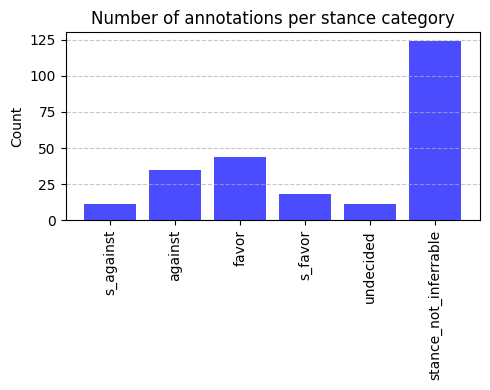

In [50]:
# distribution of the stance categories
PyPlot.figure(figsize=(5, 4))

PyPlot.bar(stance_categories, [annotations_count[cat] for cat in stance_categories], color="blue", alpha=0.7)

PyPlot.title("Number of annotations per stance category")
# PyPlot.xlabel("Stance Categories")
PyPlot.ylabel("Count")

PyPlot.xticks(rotation=90)
PyPlot.grid(axis="y", linestyle="--", alpha=0.7)

PyPlot.tight_layout()
PyPlot.gcf()

In [51]:
subreddits = spinos_df[!, "subreddit"]
subreddits_count = counter(subreddits)

Dict{Any, Any} with 3 entries:
  "r/climate"         => 25
  "r/climateskeptics" => 120
  "r/climatechange"   => 98

## Loading GPT labels

In [23]:
gpt3_output_df = CSV.read(ENV["GPT3_LABELS"], DataFrame);
gpt4_output_df = CSV.read(ENV["GPT4_LABELS"], DataFrame);

In [24]:
size(gpt3_output_df), size(gpt4_output_df)

((138, 15), (138, 15))

In [4]:
first(gpt3_output_df, 2)

Row,author_id,title,content,annotation,topic,subreddit,is_sarcastic,is_unsure,is_explicit,top_level_post,top_level_post_id,parents,parent_ids,timestamp,predicted_stance_scores
,String,String?,String,String31,String15,String31,String3?,String3?,String3?,String3,String7?,String3,String?,String31,String7
1,8b85933a25ccc437444d48dcd8fbb0d82d997db28b50cb8c93b6f1cb030c64c2,missing,"They are connected. The best way to provoke is through fear, and we are being overdosed with fear, of the weather, the police, a virus, economic hard times, etc, etc. Oddly though, it seems like the fear of one thing is contradicting the other. Like Covid-19 is so highly infectious, yet there are crowds of protesters in every major US city no longer social distancing, which was supposed to be so necessary to avoid it's spread. For instance, almost [none of the protesters in Seattle tested appear to be positive](https://komonews.com/news/local/fewer-than-1-of-seattle-protesters-test-positive-for-coronavirus). As well, the research behind hydroxychloroquine which was deemed as ineffective and dangerous to use in treating Covid-19, looks to have been a complete sham orchestrated by a one-man company called Surgisphere. Somehow those esteened medical journals the Lancet and NEJM, published obviously fraudulent papers that were never peer-reviewed, if peer-review means anything at all. So you can just imagine how much BS climate papers get published.",against,climate-change,r/climateskeptics,No,No,No,No,h7qmqy,0,"['funkrzc', 'funlh7z']",2020-06-13 02:27:21,0.1
2,b066f2f2eb9da3ba5756c2bc906d52cc565076af784fae47303466c6dc2a517b,missing,"The arctic will be ice free by 2013. There, that's one. Or, do you mean only predictions made in published science articles that were written by people with PhDs in Climate Science? If you are going to narrow it down to that very specific, I might have to do 5 mintues of research. I don't rail against the predictions of climate scientists that are published in respectable journals, per se, but at the entirety of the climate reporting and hysteria that happens. I can't object to incorrect predictions and claims that are published in mainstream media?",against,climate-change,r/climateskeptics,No,No,No,No,hnfssi,No,"['fxbgekf', 'fxbi5yx']",2020-07-08 20:36:38,0.2


## Utils

In [5]:
labels = [0, 1, 2, 3, 4]
target_names = ["Strong_disagree", "Disagree", "Neutral/Stance_not_inferrable", "Agree", "Strong_agree"]
ticks = [round(val, digits=2) for val in range(0.05, 1.0, step=0.05)];

In [6]:
function eval_inversions(true_labels, predicted_labels)
    cnt = 0
    
    for i in 1:length(true_labels)
        true_val = true_labels[i]
        pred = predicted_labels[i]
        
        neg = Set([0, 1])
        pos = Set([3, 4])
        
        if (true_val in pos && pred in neg) || (true_val in neg && pred in pos)
            cnt += 1
        end
    end
    
    return cnt
end

eval_inversions (generic function with 1 method)

In [7]:
function my_auc(true_labels, predicted_scores)
    sorted_scores_id = sortperm(predicted_scores, rev=true)
    
    cnt = 0
    total = 0
    
    for (index, i) in enumerate(sorted_scores_id)
        for j in sorted_scores_id[index+1:end]
            true_labels[i] == true_labels[j] && continue
            
            total += 1
            
            if true_labels[i] > true_labels[j]
                cnt += 1
            end
        end
    end
    
    return cnt / total
end

my_auc (generic function with 1 method)

In [15]:
function find_best_thrs(true_labels_classes, predicted_scores, target_names, ni_indices, ticks, r=4)
    best_k = 0
    best_comb_k = nothing

    best_acc = 0
    best_comb_acc = nothing
    best_cm = nothing
    best_cr = nothing

    best_RMSE = Inf
    best_comb_RMSE = nothing

    best_inversions = Inf
    best_comb_inversions = nothing

    best_auc = 0
    best_comb_auc = nothing

    done = 0
    
    # Calculate total combinations for progress tracking
    n_comb = binomial(length(ticks), r)

    for comb in combinations(ticks, r)
        # Calculate NI score
        ni_score = ticks[1] + (ticks[2] - ticks[1])/2 #(ticks[1] + ticks[2]) / 2
        _predicted_scores = [typeof(score) <: Number ? Float64(score) : ni_score for score in predicted_scores]

        # Binning
        bins = np.digitize(_predicted_scores, bins=comb)

        # Set 'NI' class to a number
        for i in ni_indices
            bins[i] = 2  # neutral
        end

        k = sklearn_metrics.cohen_kappa_score(true_labels_classes, bins, labels=labels, weights="quadratic")
        acc = sklearn_metrics.accuracy_score(true_labels_classes, bins)
        rmse = sqrt(sklearn_metrics.mean_squared_error(true_labels_classes, bins))
        inv = eval_inversions(true_labels_classes, bins)
        auc = my_auc(true_labels_classes, _predicted_scores)
        
        if k > best_k
            best_k = k
            best_comb_k = comb
        end

        if acc > best_acc
            best_acc = acc
            best_comb_acc = comb
            best_cm = sklearn_metrics.confusion_matrix(true_labels_classes, bins, labels=labels)
            best_cr = sklearn_metrics.classification_report(true_labels_classes, bins, labels=labels, target_names=target_names)
        end

        if rmse < best_RMSE
            best_RMSE = rmse
            best_comb_RMSE = comb
        end

        if inv < best_inversions
            best_inversions = inv
            best_comb_inversions = comb
        end

        if auc > best_auc
            best_auc = auc
            best_comb_auc = comb
        end

        done += 1

        if done % 1000 == 0
            println("$done/$n_comb")
        end
    end

    to_return = Dict(
        "best_k" => best_k,
        "best_comb_k" => best_comb_k,
        "best_acc" => best_acc,
        "best_comb_acc" => best_comb_acc,
        "best_cm" => best_cm,
        "best_cr" => best_cr,
        "best_RMSE" => best_RMSE,
        "best_comb_RMSE" => best_comb_RMSE,
        "best_inversions" => best_inversions,
        "best_comb_inversions" => best_comb_inversions,
        "best_auc" => best_auc,
        "best_comb_auc" => best_comb_auc
    )

    return to_return
end

find_best_thrs (generic function with 2 methods)

## Evaluation

In [29]:
gpt3_true_label_scores = map(
    x -> Dict(
            "s_against" => 0, 
            "against" => 1, 
            "Neutral" => 2, 
            "favor" => 3, 
            "s_favor" => 4, 
            "stance_not_inferrable" => 2)[x], 
            gpt3_output_df[!, :annotation]
    );

gpt4_true_label_scores = map(
    x -> Dict(
            "s_against" => 0, 
            "against" => 1, 
            "Neutral" => 2, 
            "favor" => 3, 
            "s_favor" => 4, 
            "stance_not_inferrable" => 2)[x], 
            gpt4_output_df[!, :annotation]
    );

In [25]:
gpt3_scores = gpt3_output_df[!, "predicted_stance_scores"]
# transform the scores into floats
gpt3_scores = [(score_str != "NI") ? parse(Float64, score_str) : "NI" for score_str in gpt3_scores];

gpt4_score = gpt4_output_df[!, "predicted_stance_scores"]
# transform the scores into floats
gpt4_scores = [(score_str != "NI") ? parse(Float64, score_str) : "NI" for score_str in gpt4_score];

In [26]:
# find all indices where NI appears
gpt3_ni_indices = findall(x -> x == "NI", gpt3_scores);
gpt4_ni_indices = findall(x -> x == "NI", gpt4_scores);

In [ ]:
gpt3_res = find_best_thrs(
    gpt3_true_label_scores, 
    gpt3_scores, 
    target_names, 
    gpt3_ni_indices, 
    ticks, 
    4
);

1000/4845
2000/4845
3000/4845
4000/4845


In [30]:
gpt4_res = find_best_thrs(
    gpt4_true_label_scores, 
    gpt4_scores, 
    target_names, 
    gpt4_ni_indices, 
    ticks, 
    4
);

1000/4845
2000/4845
3000/4845
4000/4845


In [21]:
# print all results
println("Best Cohen Kappa: ", gpt3_res["best_k"])
println("Best Kappa Combination: ", gpt3_res["best_comb_k"])

println("Best Accuracy: ", gpt3_res["best_acc"])
println("Best Confusion Matrix: ", gpt3_res["best_cm"])
println("Best Classification Report: ", gpt3_res["best_cr"])
println("Best Accuracy Combination: ", gpt3_res["best_comb_acc"])

println("Best RMSE: ", gpt3_res["best_RMSE"])
println("Best RMSE Combination: ", gpt3_res["best_comb_RMSE"])

println("Best Inversions: ", gpt3_res["best_inversions"])
println("Best Inversions Combination: ", gpt3_res["best_comb_inversions"])

println("Best AUC: ", gpt3_res["best_auc"])

Best Cohen Kappa: 0.38914936369725384
Best Kappa Combination: [0.05, 0.25, 0.65, 0.7]
Best Accuracy: 0.39855072463768115
Best Confusion Matrix: [5 6 0 0 0; 8 25 0 2 0; 11 8 9 1 1; 12 13 3 14 2; 0 8 0 8 2]
Best Classification Report:                                precision    recall  f1-score   support

              Strong_disagree       0.14      0.45      0.21        11
                     Disagree       0.42      0.71      0.53        35
Neutral/Stance_not_inferrable       0.75      0.30      0.43        30
                        Agree       0.56      0.32      0.41        44
                 Strong_agree       0.40      0.11      0.17        18

                     accuracy                           0.40       138
                    macro avg       0.45      0.38      0.35       138
                 weighted avg       0.51      0.40      0.40       138

Best Accuracy Combination: [0.05, 0.55, 0.6, 1.0]
Best RMSE: 1.4295028019803129
Best RMSE Combination: [0.05, 0.1, 0.65, 1.0]

In [31]:
# print all results
println("Best Cohen Kappa: ", gpt4_res["best_k"])
println("Best Kappa Combination: ", gpt4_res["best_comb_k"])

println("Best Accuracy: ", gpt4_res["best_acc"])
println("Best Confusion Matrix: ", gpt4_res["best_cm"])
println("Best Classification Report: ", gpt4_res["best_cr"])
println("Best Accuracy Combination: ", gpt4_res["best_comb_acc"])

println("Best RMSE: ", gpt4_res["best_RMSE"])
println("Best RMSE Combination: ", gpt4_res["best_comb_RMSE"])

println("Best Inversions: ", gpt4_res["best_inversions"])
println("Best Inversions Combination: ", gpt4_res["best_comb_inversions"])

println("Best AUC: ", gpt4_res["best_auc"])

Best Cohen Kappa: 0.5355648535564854
Best Kappa Combination: [0.1, 0.45, 0.55, 0.8]
Best Accuracy: 0.5507246376811594
Best Confusion Matrix: [3 6 0 2 0; 1 28 3 3 0; 2 9 13 6 0; 1 10 4 29 0; 1 3 1 10 3]
Best Classification Report:                                precision    recall  f1-score   support

              Strong_disagree       0.38      0.27      0.32        11
                     Disagree       0.50      0.80      0.62        35
Neutral/Stance_not_inferrable       0.62      0.43      0.51        30
                        Agree       0.58      0.66      0.62        44
                 Strong_agree       1.00      0.17      0.29        18

                     accuracy                           0.55       138
                    macro avg       0.61      0.47      0.47       138
                 weighted avg       0.61      0.55      0.53       138

Best Accuracy Combination: [0.1, 0.45, 0.55, 0.95]
Best RMSE: 1.0700128673207085
Best RMSE Combination: [0.05, 0.15, 0.55, 0.95]